In [315]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [316]:
x,y = [], []
with open("bicycle.txt") as bicycle:
    for line in bicycle:
        row = line.split()
        x.append(float(row[0]))
        y.append(float(row[1]))

data = np.array(list(zip(x,y)))
print(data[500:510])

[[0.21965318 0.94470046]
 [0.22254335 0.94470046]
 [0.22543353 0.94470046]
 [0.2283237  0.94470046]
 [0.23121387 0.94470046]
 [0.23410405 0.94470046]
 [0.23699422 0.94470046]
 [0.23988439 0.94470046]
 [0.24277457 0.94470046]
 [0.24566474 0.94470046]]


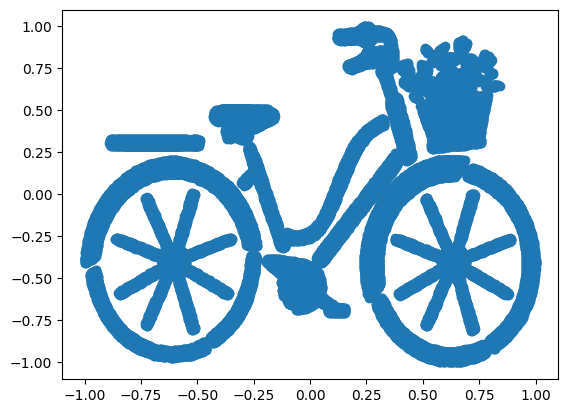

In [317]:
# 2-dimensional distribution of data - target distribution we'll try to approximate
# colorful image of dimensions 32x32x3 will be considered as one point of similar distribution. except 3072-dimensional
plt.scatter(x,y)

In [318]:
# Let's try to add noise to each point

In [319]:
n_steps = 1000 # number of noiseadding steps

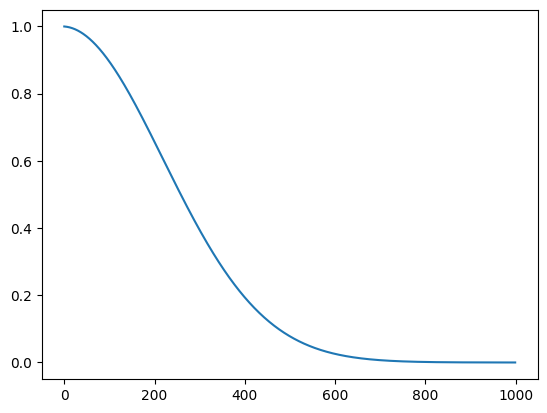

In [320]:
# parameters
betas = np.linspace(0.0001,0.02,n_steps)
alphas = 1 - betas
alpha_prods = np.cumprod(alphas)
plt.plot(alpha_prods)

In [321]:
# This method falls down to zero too quickly. We need another one
# turns out if we swap the range to 

In [322]:
steps = (np.arange(0,n_steps)-n_steps/2)/100
betas = np.exp(steps)/(1+np.exp(steps))
betas = betas*0.0101188381035 # value chosen by trial and error :)

0.49750365032222976


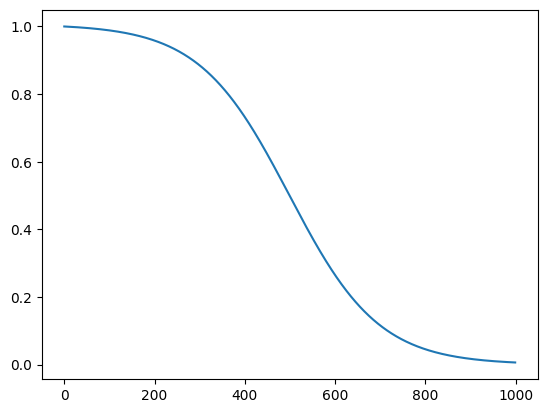

In [323]:
alphas = 1-betas
alpha_prods = np.cumprod(alphas)
print(alpha_prods[500])
plt.plot(alpha_prods)

In [324]:
# adding noise to the data

In [325]:
I = np.identity(2)
N = len(data)

In [342]:
noise = np.random.multivariate_normal((0,0),I,N*n_steps).reshape((n_steps,N,2)) *(1-alpha_prods).reshape(n_steps,1,1)

In [349]:
data_means = data*np.sqrt(alpha_prods).reshape((1000,1,1))

In [350]:
iterations = noise+data_means

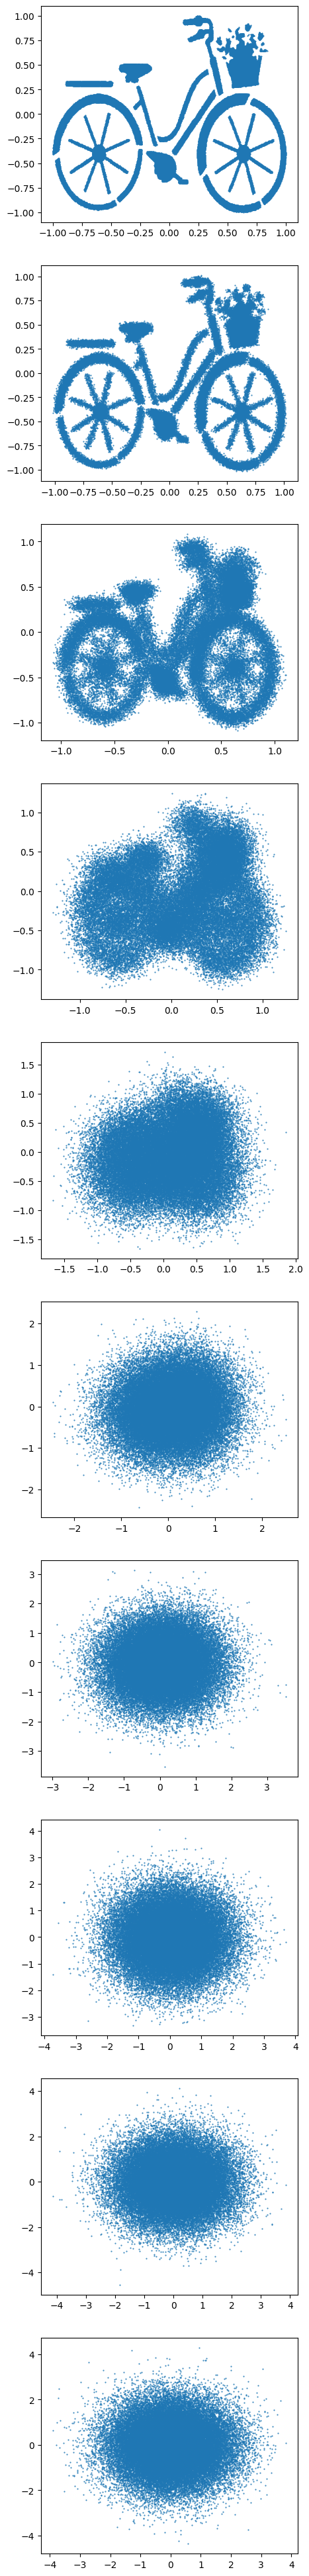

In [368]:
figure, axis = plt.subplots(10,figsize=(5,50))

for i in range(10):
    axis[i].scatter(iterations[i*100,:,0],iterations[i*100,:,1],marker=".",s=1)

plt.show()